# A/B testing

When a user lands on our Web site, we randomly show them design A or B, and record
this assignment. After enough visitors have done this, we join this dataset against some
metric of interest (typically, for Web sites, we are interested in a purchase or signup). For
example, consider the following numbers:

In [1]:
import warnings
warnings.simplefilter("ignore")

visitors_to_A = 1300
visitors_to_B = 1275

conversions_from_A = 120
conversions_from_B = 125

we want to calculate the probability a user is "converted" for sites A and B
The probability can be modeled by a Beta distribution
The outcomes of the experiment follow a Binomial (trials=visitors, sucesses=conversions)

beta_posterior~beta_prior * binomial_likelihood

beta_posterior(a0+X,b0+N-X)~beta_prior(ao,bo) * binomial_likelihood(trials=N,successes=X)

In [2]:
from scipy.stats import beta
alpha_prior = 1
beta_prior = 1
posterior_A = beta(alpha_prior + conversions_from_A,
beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B,
beta_prior + visitors_to_B - conversions_from_B)

Next, we’d like to determine which group has a large probability of conversion. To do this, similar to MCMC, 
we use samples from the posterior and compare the probability
that samples from the posterior of A are larger than samples from the posterior of B.
We use the rvs method to generate samples.

In [3]:
samples = 200000 # We want this to be large to get a better approximation.
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)
print((samples_posterior_A > samples_posterior_B).mean())

0.30979


So we can see here that there is a 31% chance that site A converts better than site B.
(Conversely, there is a 69% chance that site B converts better than A.) This is not very
significant; consider that if we reran this experiment with identical pages, it would return a
probability close to 50%.

Let's vidualise the posterior

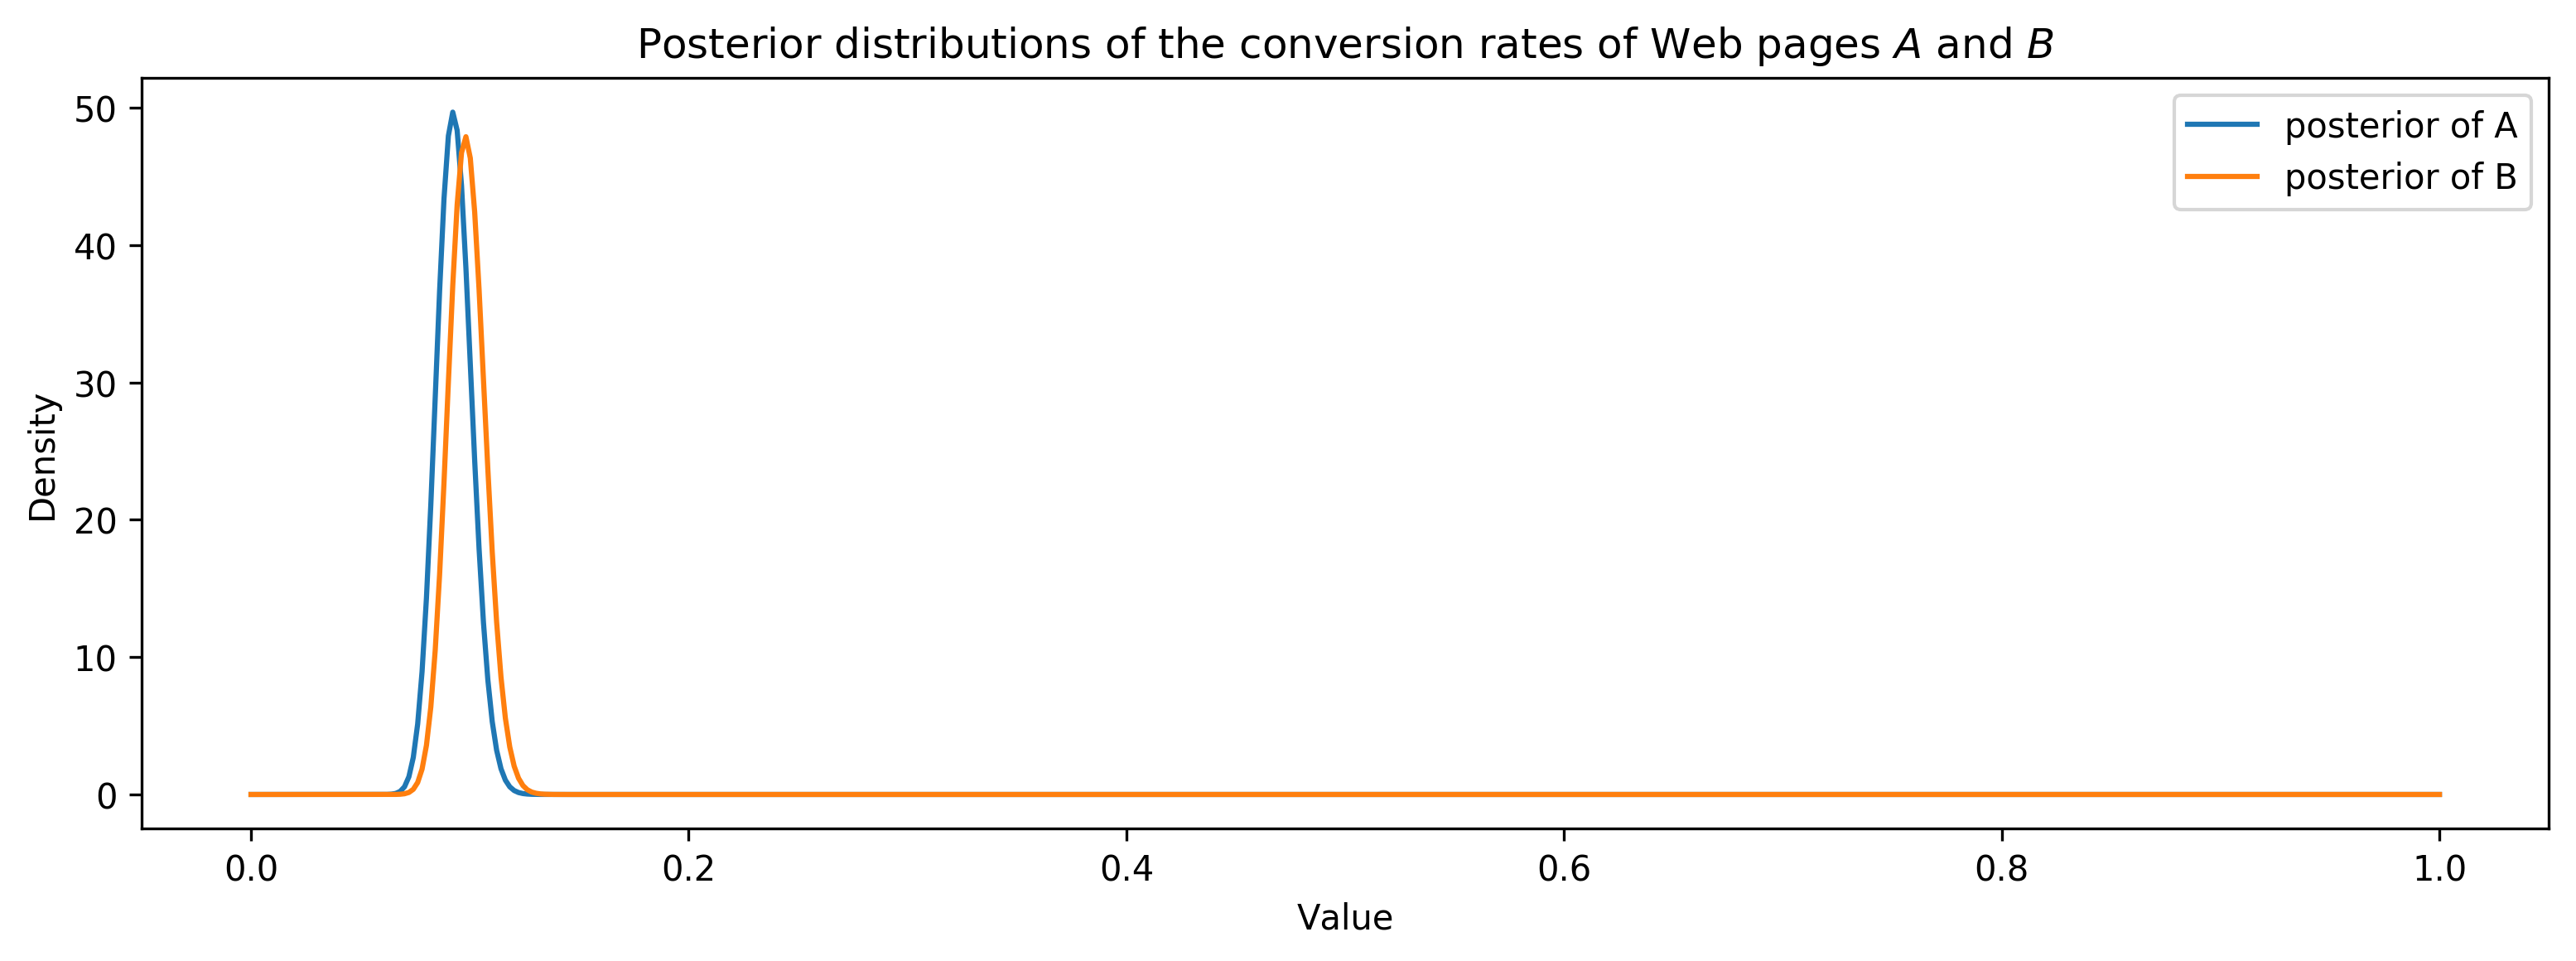

In [4]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt
import numpy as np
figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

x = np.linspace(0,1, 500)
plt.plot(x, posterior_A.pdf(x), label='posterior of A')
plt.plot(x, posterior_B.pdf(x), label='posterior of B')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the conversion rates of Web pages $A$ and $B$")
plt.legend()


Let's zoom in

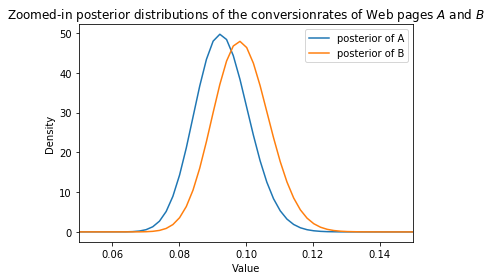

In [5]:
plt.plot(x, posterior_A.pdf(x), label='posterior of A')
plt.plot(x, posterior_B.pdf(x), label='posterior of B')
plt.xlim(0.05, 0.15)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Zoomed-in posterior distributions of the conversion\
rates of Web pages $A$ and $B$")
plt.legend();

# Modelling multiple selections

Let's say that besides modelling the probabilities of a user converting based on A or B we want to know if presented with price plans which one they select based on A/B. 

The expected revenus is then E[R]=79$p_{79}$+49$p_{49}$+25$p_{25}$+0$p_{0}$

where $p_{79}$, $p_{49}$, $p_{25}$, $p_{0}$ are the probabilities of selecting each plan. These probabilities must sum to one. So are not independent and we cannot model them after the Binomial. We use the Multinomial instead.

In [6]:
from numpy.random import multinomial
# with len(P)=2 we recover the Binomial
P = [0.4, 0.6]
N = 100
print(multinomial(N, P))

P = [0.5, 0.2, 0.3]
N = 100
print(multinomial(N, P))

[34 66]
[42 24 34]


Ok, so this is our likelihood but how to we model the probabilities. Before we used the Beta but now we have a vector of probabilities that need to sum to 1. We use the Dirichlet for this.

In [7]:
from numpy.random import dirichlet
sample = dirichlet([1,1]) # [1,1] is equivalent to a Beta(1,1)
# distribution.
print(sample)
print(sample.sum())


sample = dirichlet([1,1,1,1])
# distribution.
print(sample)
print(sample.sum())


[0.04273632 0.95726368]
0.9999999999999999
[0.23180544 0.42606222 0.24252025 0.09961209]
1.0


The Dirichlet is the conjugate of the Multinomial!

The posterior of the Dirichlet is Dirichlet(1+N1,1+N2,...,1+N$_{m}$)

In [8]:
N = 1000 #Suppose 1,000 people view the page
N_79 = 10
N_49 = 46
N_25 = 80
N_0=N - (N_79 + N_49 + N_49)
observations = np.array([N_79, N_49, N_25, N_0])
prior_parameters = np.array([1,1,1,1])
posterior_samples = dirichlet(prior_parameters + observations,size=10000)
print("Two random samples from the posterior:")
print(posterior_samples[0])
print(posterior_samples[1])

Two random samples from the posterior:
[0.01501427 0.03567877 0.08574843 0.86355853]
[0.00865415 0.04591479 0.08667203 0.85875903]


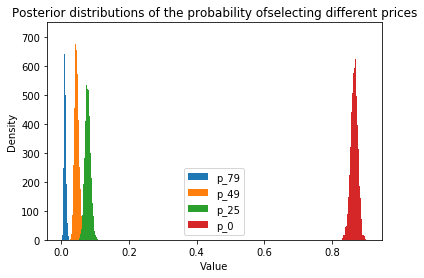

In [9]:
for i, label in enumerate(['p_79', 'p_49', 'p_25', 'p_0']):
    ax = plt.hist(posterior_samples[:,i], bins=50,label=label, histtype='stepfilled')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the probability of\
selecting different prices")
plt.legend();

This approach should feel a lot like using a loss function, as that is essentially what we are
doing: We are estimating parameters, then passing them through a loss function to relate
them back to the real world.

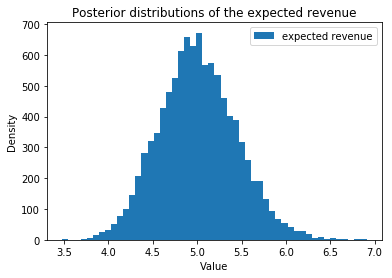

In [10]:
def expected_revenue(P):
    return 79*P[:,0] + 49*P[:,1] + 25*P[:,2] + 0*P[:,3]

posterior_expected_revenue = expected_revenue(posterior_samples)
plt.hist(posterior_expected_revenue, histtype='stepfilled',label='expected revenue', bins=50)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the expected revenue")
plt.legend();

# Extending multiple selections to A/B testing

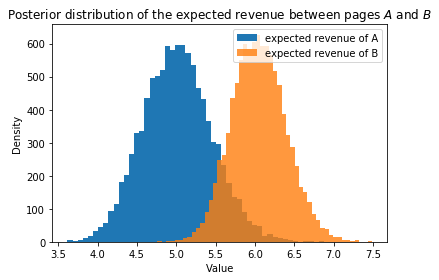

In [11]:
N_A= 1000
N_A_79 = 10
N_A_49 = 46
N_A_25 = 80
N_A_0 = N_A - (N_A_79 + N_A_49 + N_A_49)
observations_A = np.array([N_A_79, N_A_49, N_A_25, N_A_0])

N_B = 2000
N_B_79 = 45
N_B_49 = 84
N_B_25 = 200
N_B_0 = N_B - (N_B_79 + N_B_49 + N_B_49)
observations_B = np.array([N_B_79, N_B_49, N_B_25, N_B_0])

prior_parameters = np.array([1,1,1,1])

posterior_samples_A = dirichlet(prior_parameters + observations_A,size=10000)
posterior_samples_B = dirichlet(prior_parameters + observations_B,size=10000)

posterior_expected_revenue_A = expected_revenue(posterior_samples_A)
posterior_expected_revenue_B = expected_revenue(posterior_samples_B)

plt.hist(posterior_expected_revenue_A, histtype='stepfilled',label='expected revenue of A', bins=50)
plt.hist(posterior_expected_revenue_B, histtype='stepfilled',label='expected revenue of B', bins=50, alpha=0.8)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the expected revenue between pages $A$ and $B$")
plt.legend();

In [12]:
p = (posterior_expected_revenue_B > posterior_expected_revenue_A).mean()
print("Probability that page B has a higher revenue than page A: {0:.2%}".format(p))

Probability that page B has a higher revenue than page A: 96.77%


Another interesting plot to look at is the posterior difference in revenue between the
pages. We get this for free since we are using Bayesian analysis; we
simply look at the histogram of the difference of the two expected revenue posteriors.

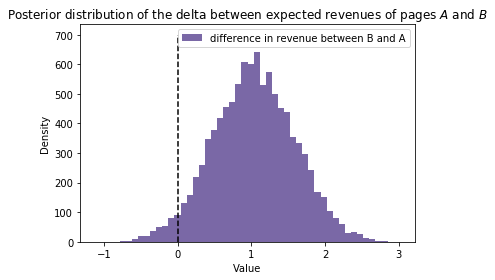

In [13]:
posterior_diff = posterior_expected_revenue_B - posterior_expected_revenue_A
plt.hist(posterior_diff, histtype='stepfilled', color='#7A68A6',label='difference in revenue between B and A', bins=50)
plt.vlines(0, 0, 700, linestyles='--')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the delta between expected revenues of pages $A$ and $B$")
plt.legend();

Looking at this posterior, we see that there is about a 50% chance that the difference is
more than \$1 and possibly even larger than \$2. And if we are wrong about our choice of B
(which is possible), we probably won’t lose much: The distribution doesn’t extend much
past −\$0.50.

# BEST Bayesian Estimation Supersedes the t-test

Following our A/B testing theme, suppose we have data about the length of time a user is
on a test page. This data is not binary; it’s continuous. For example, we’ll create some
artificial data with the following code:

In [14]:
N = 250
mu_A, std_A = 30, 4
mu_B, std_B = 26, 7
# create durations (seconds) users are on the pages for
durations_A = np.random.normal(mu_A, std_A, size=N)
durations_B = np.random.normal(mu_B, std_B, size=N)

Our task is to determine on which page, A or B, users stay longer. We have five
unknowns for this model, two mean parameters (denoted by μ), two standard deviation
parameters (denoted σ ), and one additional model unique to t-tests: ν (pronounced “nu”).
The ν parameter sets how likely we are to see large outliers in our data. According to the
BEST model, our priors for the unknowns are as follows.

In [15]:
import pymc3 as pm
pooled_mean = np.r_[durations_A, durations_B].mean()
pooled_std = np.r_[durations_A, durations_B].std()
tau = 1./np.sqrt(1000.*pooled_std) # PyMC uses a precision parameter, 1/sigma**2

with pm.Model() as model:
#     μA and μB come from a Normal distribution with prior mean equal to the pooled
#     mean of data from A and B, and prior standard deviation equal to 1,000 times the
#     pooled standard deviation. (This is a very wide, uniformative prior.)
    mu_A = pm.Normal("mu_A", mu=pooled_mean, tau=tau)
    mu_B = pm.Normal("mu_B", mu=pooled_mean, tau=tau)
#     σA and σB come from a uniform distribution, restricted to one one-thousandths of
#     the pooled standard deviation, to 1000 times the standard deviation. (Again, a very
#     wide uninformative prior).
    std_A = pm.Uniform("std_A", pooled_std/1000., 1000.*pooled_std)
    std_B = pm.Uniform("std_B", pooled_std/1000., 1000.*pooled_std)
#     Finally, ν is estimated from a shifted exponential distribution with parameter equal
#     to 29. For more details about why this was chosen, it is detailed in Appendix A of
#     [1]. One interesting detail of BEST is that ν is shared between the two groups. This
#     will be clearer in the following diagram.
    nu_minus_1 = pm.Exponential("nu-1", 1./29)    
# Let’s finish putting the pieces model of the model together:
    obs_A = pm.StudentT("obs_A", mu=mu_A, sd=std_A, nu=nu_minus_1 + 1, observed=durations_A)
    obs_B = pm.StudentT("obs_B", mu=mu_B, sd=std_B, nu=nu_minus_1 + 1, observed=durations_B)    
    step=pm.NUTS([mu_A,mu_B,std_A,std_B,nu_minus_1,obs_A,obs_B])
    trace = pm.sample(50000, step=step,tune=10000,target_accept=0.9)

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [nu-1, std_B, std_A, mu_B, mu_A]
Sampling 4 chains: 100%|██████████| 240000/240000 [01:22<00:00, 2907.09draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.


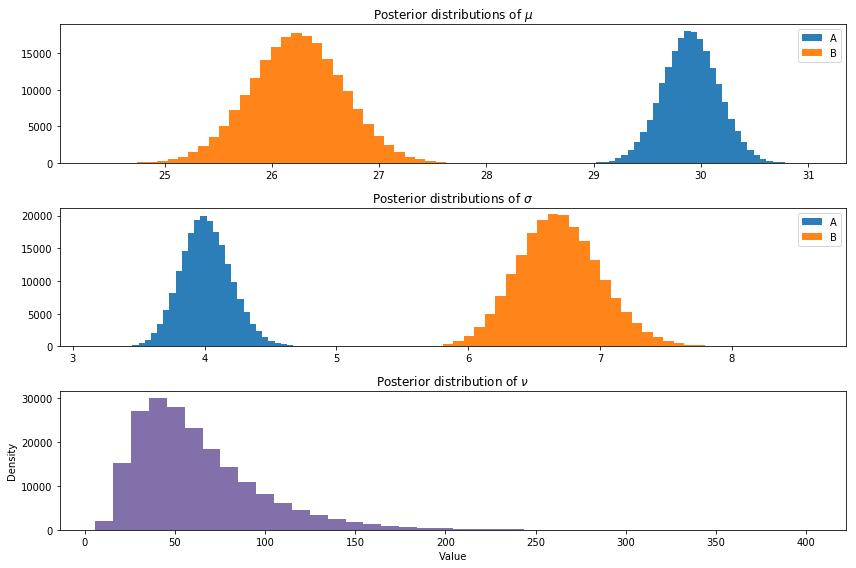

In [16]:
mu_A_trace, mu_B_trace = trace['mu_A'][:], trace['mu_B'][:]
std_A_trace, std_B_trace = trace['std_A'][:], trace['std_B'][:]
nu_trace = trace["nu-1"][:] + 1

figsize(12,8)
def _hist(data, label, **kwargs):
    return plt.hist(data, bins=40, histtype='stepfilled',alpha=.95, label=label, **kwargs)

ax = plt.subplot(3,1,1)
_hist(mu_A_trace,'A')
_hist(mu_B_trace,'B')
plt.legend()
plt.title('Posterior distributions of $\mu$')
ax = plt.subplot(3,1,2)
_hist(std_A_trace, 'A')
_hist(std_B_trace, 'B')
plt.legend()
plt.title('Posterior distributions of $\sigma$')
ax = plt.subplot(3,1,3)
_hist(nu_trace,'', color='#7A68A6')
plt.title(r'Posterior distribution of $\nu$')
plt.xlabel('Value')
plt.ylabel('Density')
plt.tight_layout();

# Estimating the Increase

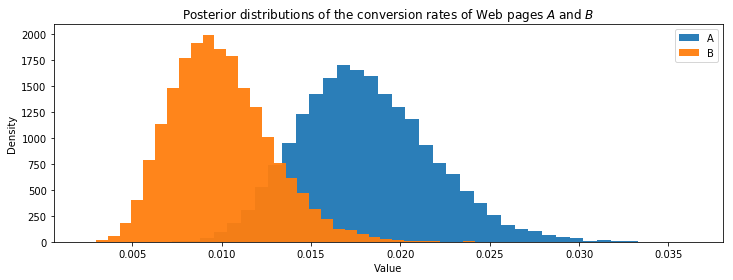

In [17]:
figsize(12,4)

visitors_to_A = 1275
visitors_to_B = 1300

conversions_from_A = 22
conversions_from_B = 12

alpha_prior = 1
beta_prior = 1

posterior_A = beta(alpha_prior + conversions_from_A, beta_prior + visitors_to_A - conversions_from_A)
posterior_B = beta(alpha_prior + conversions_from_B, beta_prior + visitors_to_B - conversions_from_B)

samples = 20000
samples_posterior_A = posterior_A.rvs(samples)
samples_posterior_B = posterior_B.rvs(samples)

_hist(samples_posterior_A, 'A')
_hist(samples_posterior_B, 'B')

plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distributions of the conversion rates of Web pages $A$ and $B$")
plt.legend();

We’ll pass the posteriors through a function that computes the relative increase pairwise.

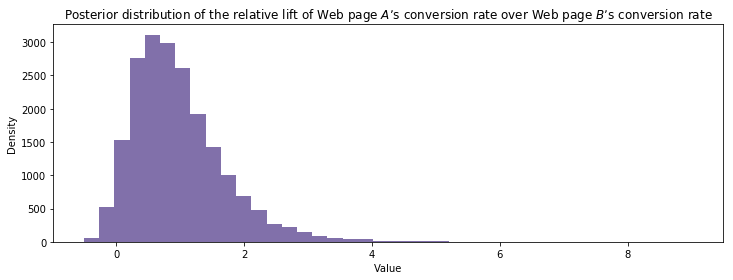

In [18]:
def relative_increase(a,b):
    return (a-b)/b

posterior_rel_increase = relative_increase(samples_posterior_A, samples_posterior_B)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Posterior distribution of the relative lift of Web page $A$’s conversion rate over Web page $B$’s conversion rate")
_hist(posterior_rel_increase, 'relative increase', color='#7A68A6');

From the figure above and the next calculation, we can see that there is an 89% chance that
the relative increase is 20% or more. Furthermore, there is a 72% chance that the increase
is as great as 50%

In [19]:
print((posterior_rel_increase > 0.2).mean())
print((posterior_rel_increase > 0.5).mean())

0.8965
0.7212


If we were naively going to use point estimates, which would be (mean(p$_{A}$)-mean(p$_{B}$)/mean(p$_{B}$))

# Creating Point Estimates

As I’ve said before, it is rude to hand over a distribution to someone, especially to a
business unit who is expecting a single number. So what do you do? There are three
options as I see it:
1. Return the mean of the posterior relative increase distribution. I actually don’t like
this suggestion, and I left it in to explain why. Looking at the last figure, we can see a
long right tail of possible values. This implies a skewed distribution. When we have
a skewed distribution, a summary statistic like the mean is overly influenced by the
tail, hence we would be overrepresenting the tail and overestimating the true relative
increase.
2. Return the median of the posterior relative increase distribution. In light of the
previous discussion, the median is a more appropriate choice. The median is more
robust to skewed distributions. In practice, though, I’ve found the median to still
give an overly inflated value.
3. Return a percentile (less than 50%) of the posterior relative increase distribution.
For example, return the 30th percentile of the distribution. This has two desirable
properties. The first is that it is mathematically equivalent to applying a loss function
on top of the relative increase posterior that penalizes overestimates more than
underestimates, hence this value is a conservative estimate. Secondly, as we get more
and more data from our experiment, the relative increase posterior distribution gets
skinnier and skinnier, meaning any percentiles eventually converge to the same
point.

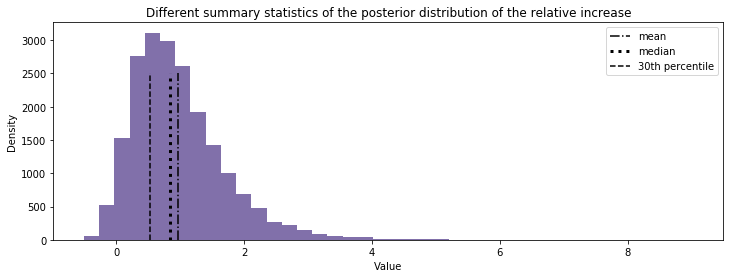

In [20]:
mean = posterior_rel_increase.mean()
median = np.percentile(posterior_rel_increase, 50)
conservative_percentile = np.percentile(posterior_rel_increase, 30)
_hist(posterior_rel_increase,'', color='#7A68A6');
plt.vlines(mean, 0, 2500, linestyles='-.', label='mean')
plt.vlines(median, 0, 2500, linestyles=':', label='median', lw=3)
plt.vlines(conservative_percentile, 0, 2500, linestyles='--',
label='30th percentile')
plt.xlabel('Value')
plt.ylabel('Density')
plt.title("Different summary statistics of the posterior distribution of the relative increase")
plt.legend();

In [21]:
import sys, IPython, scipy, matplotlib, platform, tiingo
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was created on a x86_64 computer running debian buster/sid and using:
Python 3.7.2
IPython 7.2.0
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2
